Hi all General
 
Yesterday I learned about an interesting project that Peter Lambooij, teacher-researcher at Fontys, is conducting together with chemical experts from TU/e and other institutes. They try to create a robot that can conduct chemical experiments, which is very very ambitious and long-term.
 
One of the many small steps in this research is extracting useful information from old chemical scientific charts. Like this:
 



1/1 [==============================] - 1s 817ms/step


c:\Users\maxwe\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\maxwe\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


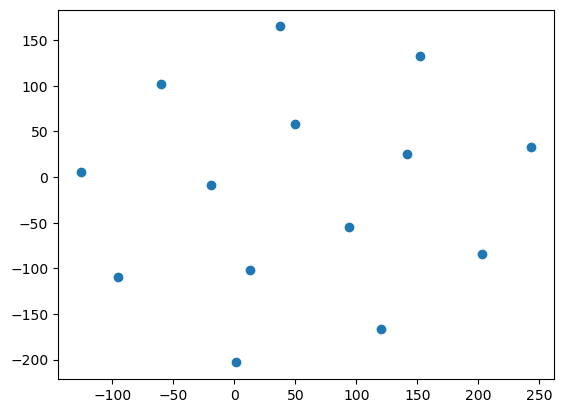

In [54]:
import numpy as np
import torch.nn.functional as F
import os
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Load the ResNet50 model
model = ResNet50(weights='imagenet', include_top=False)

# Load the images
image_dir = 'ChemicalCharts/'
images = []
for filename in os.listdir(image_dir):
    img_path = os.path.join(image_dir, filename)
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img)
    images.append(img)
x = [image[:, :, :3] for image in images]

# Preprocess the images
x = preprocess_input(np.array(x))

# Use the model to extract features from the images
features = model.predict(x)

# Concatenate the feature vectors into a 2D array
features = features.reshape(len(images), -1)

# Reduce the dimensionality of the feature vector using t-SNE
tsne = TSNE(n_components=2, random_state=0)
tsne_features = tsne.fit_transform(features)

# Plot the t-SNE features
plt.scatter(tsne_features[:, 0], tsne_features[:, 1])
plt.show()


In [55]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
import networkx as nx
import matplotlib.pyplot as plt

# Define the graph dataset
class GraphDataset(Dataset):
    def __init__(self, graph_dir):
        self.graphs = []
        self.graph_dir = graph_dir
        
        # Load graph images and extract graph data
        for image_file in os.listdir(graph_dir):
            graph_image = Image.open(os.path.join(graph_dir, image_file))
            graph_data = preprocess_graph_image(graph_image)  # Extract graph data from image
            self.graphs.append(graph_data)
    
    def __len__(self):
        return len(self.graphs)
    
    def __getitem__(self, index):
        return self.graphs[index]
    
    
def preprocess_graph_image(image):
    # Convert image to grayscale
    image = image.convert('L')
    
    # Threshold the image to convert it to black and white
    threshold = 128
    image = image.point(lambda x: 0 if x < threshold else 255)
    
    # Convert the image to a binary array
    graph_data = np.array(image)
    graph_data = (graph_data == 0).astype(float)
    
    # Convert the binary array to a flattened vector
    graph_data = graph_data.flatten()
    
    return graph_data
        
# Define the generator network
class Generator(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.output_dim = output_dim
        
        # Define the network layers
        self.fc1 = nn.Linear(latent_dim, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, output_dim)
        
        # Define the activation functions
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define the discriminator network
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.input_dim = input_dim
        
        # Define the network layers
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 1)
        
        # Define the activation functions
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

# Define the loss function
def loss_function(recon_data, data):
    return nn.BCELoss()(recon_data, data)

class GraphReplicationModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.encoder = nn.Linear(input_size, hidden_size)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.encoder(x))
        x = self.decoder(x)
        return x


# Define the hyperparameters
batch_size = 32
latent_dim = 100
input_size = 784  # The flattened size of the graph images
hidden_size = 256
output_size = input_size
num_epochs = 10
learning_rate = 0.001

# Create the data loader
graph_dataset = GraphDataset(graph_dir='./OriginalCharts')
graph_loader = DataLoader(dataset=graph_dataset, batch_size=batch_size, shuffle=True)

# Create the model
model = GraphReplicationModel(input_size=input_size, hidden_size=hidden_size, output_size=output_size)

# Define the optimizers
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    for i, data in enumerate(graph_loader):
        # Generate random noise for the generator
        noise = torch.randn(batch_size, latent_dim)
        
        # Generate fake graphs with the generator
        fake_graphs = model.decoder(noise)
        
        # Concatenate the real and fake graphs into one batch
        real_graphs = data
        all_graphs = torch.cat((real_graphs, fake_graphs), dim=0)
        
        # Create labels for the real and fake graphs
        real_labels = torch.ones((batch_size, 1))
        fake_labels = torch.zeros((batch_size, 1))
        all_labels = torch.cat((real_labels, fake_labels), dim=0)
        
        # Train the discriminator
        optimizer.zero_grad()
        discriminator = Discriminator(input_dim=input_size)
        discriminator_loss = loss_function(discriminator(all_graphs), all_labels)
        discriminator_loss.backward()
        optimizer.step()
        
        # Train the generator
        optimizer.zero_grad()
        generator = Generator(latent_dim=latent_dim, output_dim=output_size)
        generator_loss = loss_function(discriminator(generator(noise)), real_labels)
        generator_loss.backward()
        optimizer.step()
        
    # Print the loss after each epoch
    print('Epoch [{}/{}], Discriminator Loss: {:.4f}, Generator Loss: {:.4f}'.format(epoch+1, num_epochs, discriminator_loss.item(), generator_loss.item()))
    
# Generate a fake graph
fake_graph = generator(torch.randn(1, latent_dim))
fake_graph_data = fake_graph.detach().numpy()[0].reshape((28, 28))
G = nx.from_numpy_matrix(fake_graph_data)
nx.draw(G)
plt.show()



RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x100 and 256x784)

In [ ]:
graph_dataset = GraphDataset(graph_dir=r'C:\Users\maxwe\Documents\Github repos\ChemProject\OriginalCharts')

In [ ]:
# Generate new graphs using the trained VAE


num_samples = 10
latent_space_samples = torch.randn(num_samples, latent_dim)
generator = Generator(latent_dim, output_dim)
generated_graphs = Generator(latent_space_samples)



# Plot the generated graphs
fig, axes = plt.subplots(nrows=num_samples, ncols=1, figsize=(5,num_samples*5))
for i in range(num_samples):
    ax = axes[i]
    G = nx.from_numpy_matrix(generated_graphs[i].detach().numpy())
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, font_weight='bold', ax=ax)
    ax.set_title('Generated Graph {}'.format(i+1))
plt.show()


TypeError: empty() received an invalid combination of arguments - got (tuple, dtype=NoneType, device=NoneType), but expected one of:
 * (tuple of ints size, *, tuple of names names, torch.memory_format memory_format, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)
 * (tuple of SymInts size, *, torch.memory_format memory_format, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)


In [ ]:
latent_dim = 100
output_dim = (50, 2)
Generator = Generator(latent_dim, output_dim)

# Generate some samples from the generator
num_samples = 10
latent_space_samples = torch.randn(num_samples, latent_dim)
generated_graphs = Generator(latent_space_samples)

# Plot the generated graphs
plot_graphs(generated_graphs)

TypeError: empty() received an invalid combination of arguments - got (tuple, dtype=NoneType, device=NoneType), but expected one of:
 * (tuple of ints size, *, tuple of names names, torch.memory_format memory_format, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)
 * (tuple of SymInts size, *, torch.memory_format memory_format, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)
